In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

import os

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [204]:
# filepath = 'Bitcoin SV.csv'
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('../data', filepath))
# data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


In [205]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4420 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


In [206]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/g5/dfwv37r13p54dmy66xm4mj3h0000gq/T/ipykernel_35685/2141647733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [207]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()
    
    return [x_train, y_train, x_test, y_test]

In [208]:
# process the raw data
lookback = 5 # choose sequence length
### START CODE HERE (~1 line) ####
x_train, y_train, x_test, y_test = split_data(price, lookback)
### END CODE HERE ####
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  torch.Size([3532, 4, 1])
y_train.shape =  torch.Size([3532, 1])
x_test.shape =  torch.Size([883, 4, 1])
y_test.shape =  torch.Size([883, 1])


In [209]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
num_epochs = 200
learning_rate = 0.001

In [210]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # for t in range(x.shape[1]):
        #     _, (ht, ct) = self.lstm(x[:,t], (ht, ct))
        output, (ht, ct) = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.fc(output[:, -1, :]) 
        
        return output

In [211]:
lstm_model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [212]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = lstm_model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.81593918800354
Epoch  1 MSE:  0.775539219379425
Epoch  2 MSE:  0.7360116243362427
Epoch  3 MSE:  0.6967779397964478
Epoch  4 MSE:  0.657383143901825
Epoch  5 MSE:  0.617445170879364
Epoch  6 MSE:  0.5766317248344421
Epoch  7 MSE:  0.5346613526344299
Epoch  8 MSE:  0.4912913143634796
Epoch  9 MSE:  0.4463132619857788
Epoch  10 MSE:  0.3995659649372101
Epoch  11 MSE:  0.35096946358680725
Epoch  12 MSE:  0.3005870282649994
Epoch  13 MSE:  0.2487243264913559
Epoch  14 MSE:  0.19608330726623535
Epoch  15 MSE:  0.14399100840091705
Epoch  16 MSE:  0.0947205051779747
Epoch  17 MSE:  0.05189387872815132
Epoch  18 MSE:  0.020842766389250755
Epoch  19 MSE:  0.008355807512998581
Epoch  20 MSE:  0.01972326822578907
Epoch  21 MSE:  0.04917171224951744
Epoch  22 MSE:  0.07541342824697495
Epoch  23 MSE:  0.08332277834415436
Epoch  24 MSE:  0.0738985538482666
Epoch  25 MSE:  0.05542590841650963
Epoch  26 MSE:  0.03606455400586128
Epoch  27 MSE:  0.02096514031291008
Epoch  28 MSE:  0.01

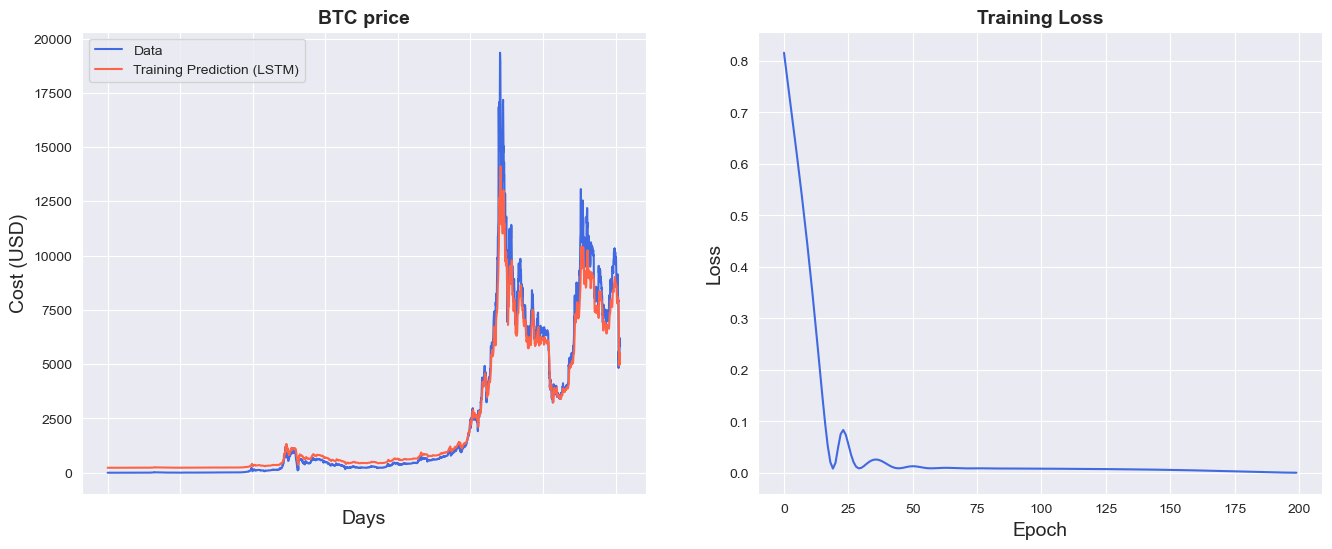

In [213]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('BTC price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


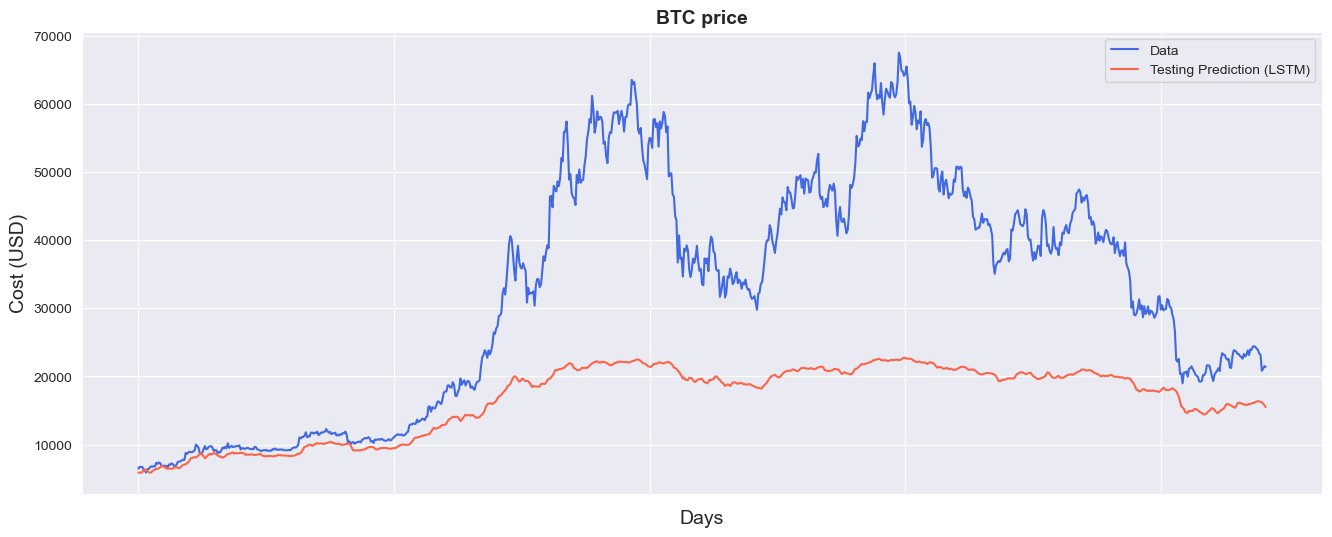

In [214]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = lstm_model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('BTC price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [215]:
# calculate root mean squared error
y_train2 = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test2 = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.59 RMSE
